# Quantum Hamiltonians simulations

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

import pickle
import glob
import os
import time
from multiprocessing import Pool

import matplotlib as mpl

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.contrib.concurrent import process_map as tqdm_parallel

from synthetic_hamiltonians import *

In [2]:
a = qt.destroy(4)
state = qt.basis(4, 3)
a

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.         1.         0.         0.        ]
 [0.         0.         1.41421356 0.        ]
 [0.         0.         0.         1.73205081]
 [0.         0.         0.         0.        ]]

In [3]:
N=3
M=2
exact_boson_number=False
dim = ponomarev_index(N, M, exact_boson_number=exact_boson_number) + 1
for index in range(1, dim):
    fock = ponomarev_to_fock(index, N,  M, exact_boson_number=exact_boson_number)
    index_out = fock_to_ponomarev(fock, N, M, exact_boson_number=exact_boson_number)
    print(index, fock, index_out)

1 [0, 3] 1
2 [1, 2] 2
3 [2, 1] 3
4 [3, 0] 4
5 [0, 2] 5
6 [1, 1] 6
7 [2, 0] 7
8 [0, 1] 8
9 [1, 0] 9
10 [0, 0] 10


In [4]:
%debug

> /Users/ben/Dropbox/Research/quantum-hamiltonians/sim/synthetic_hamiltonians/ponomarev.py(46)_find_largest_ponomarev_index_smaller_than()
     44         else:
     45             return max_index, m - 1
---> 46     raise RuntimeError("Index not found! (Shouldn't be here)")
     47 
     48 



ipdb>  up


> /Users/ben/Dropbox/Research/quantum-hamiltonians/sim/synthetic_hamiltonians/ponomarev.py(53)_ponomarev_to_fock_exact()
     51     nβ = index
     52     for n in range(N, 0, -1):
---> 53         max_index, mn = _find_largest_ponomarev_index_smaller_than(nβ, n, M)
     54         # print(f"{max_index=}, {mn=}, {nβ=}, {n=}")
     55         mj_list.append(M - mn)



ipdb>  up


> /Users/ben/Dropbox/Research/quantum-hamiltonians/sim/synthetic_hamiltonians/ponomarev.py(82)ponomarev_to_fock()
     78             max_index_n_bosons = ponomarev_index(n, M, exact_boson_number=True)
     79             if reduced_index > max_index_n_bosons:
     80                 reduced_index -= max_index_n_bosons
     81             else:
---> 82                 return _ponomarev_to_fock_exact(index, n, M)



ipdb>  index


5


ipdb>  reduced_index


1


ipdb>  q


In [6]:
%debug

> /Users/ben/Dropbox/Research/quantum-hamiltonians/sim/synthetic_hamiltonians/ponomarev.py(36)_find_largest_ponomarev_index_smaller_than()
     34         else:
     35             return max_index, m - 1
---> 36     raise RuntimeError("Index not found! (Shouldn't be here)")
     37 
     38 



ipdb>  list(range(3,0,-1))


*** Error in argument: '(range(3,0,-1))'


ipdb>  q


In [7]:
list(range(3,0,-1))

[3, 2, 1]

In [44]:
N=6
M=5
ponomarev_index(N,M)

210

In [45]:
sum(ponomarev_index(N-n, M-1) for n in range(0, N))

209

In [2]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3, linewidth=300)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=12)

## Visualization

In [3]:
# def _axes3D(fig, *args, **kwargs):
#     ax = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)
#     return fig.add_axes(ax)

# def plot_occupancies_2d_grid(state_constructed, state_actual, n_time_bins=None, n_photons=None, nx=3, ny=3, limits=None):
#     fig = plt.figure(figsize=(20,10))
#     # ax = _axes3D(fig, azim=-35, elev=35)

#     # ax1 = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)
#     # ax2 = Axes3D(fig, *args, auto_add_to_figure=False, **kwargs)

#     ax1 = fig.add_subplot(1, 2, 1, projection='3d')
#     ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
#     photon_occupancies_constructed = np.array(get_photon_occupancies(state_constructed, n_time_bins=n_time_bins, n_photons=n_photons, exclude_register=True)).reshape(ny,nx)
#     qt.matrix_histogram(photon_occupancies_constructed,fig=fig, ax=ax1, title="Constructed", colorbar=False, limits=limits)
    
#     photon_occupancies_actual = np.array(get_photon_occupancies(state_actual, n_time_bins=n_time_bins, n_photons=n_photons)).reshape(ny,nx)
#     qt.matrix_histogram(photon_occupancies_actual,fig=fig, ax=ax2, title="Actual", colorbar=False, limits=limits)
    
#     return fig
        
# state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=9, n_photons=2, full_bin_index=0, include_register=True)
# state_actual = create_initial_state_all_photons_one_bin(n_time_bins=9, n_photons=2, full_bin_index=0, include_register=False)

# fig = plot_occupancies_2d_grid(state_constructed, state_actual, limits=[0,2])
# plt.show()

In [4]:
# import glob
# # print(glob.glob("~/Dropbox/Research/quantum-hamiltonians/sim/results/*"))
# print(glob.glob("results/*"))

In [344]:
# Compare ponomarev vs non-ponomarev evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.01
tmax = 1000

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)
# state_actual_evolved = (-1j * H * t).expm() * state_actual

# Constructed evolution
state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False, use_ponomarev=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

for t in tqdm(range(0,tmax)):
    state_actual_evolved = (-1j * H * t).expm() * state_actual
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    
    fig = plt.figure(figsize=(20,10))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    photon_occupancies = np.array(get_photon_occupancies(state_actual_evolved, n_time_bins=D, n_photons=N)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies,fig=fig, ax=ax1, title="Normal", colorbar=False, limits=[0,N])

    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax2, title="Ponomarev", colorbar=False, limits=[0,N])

    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [340]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.02
μ = 0.1
U = 0.1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

# state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

for t in tqdm(range(0,tmax)):
    state_pn_evolved = (-1j * H_pn * t).expm() * state_pn
    
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    # ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
    qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax1, title="Ponomarev", colorbar=False, limits=[0,N])

    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [127]:
np.arange(0, 1, 0.2)

array([0. , 0.2, 0.4, 0.6, 0.8])

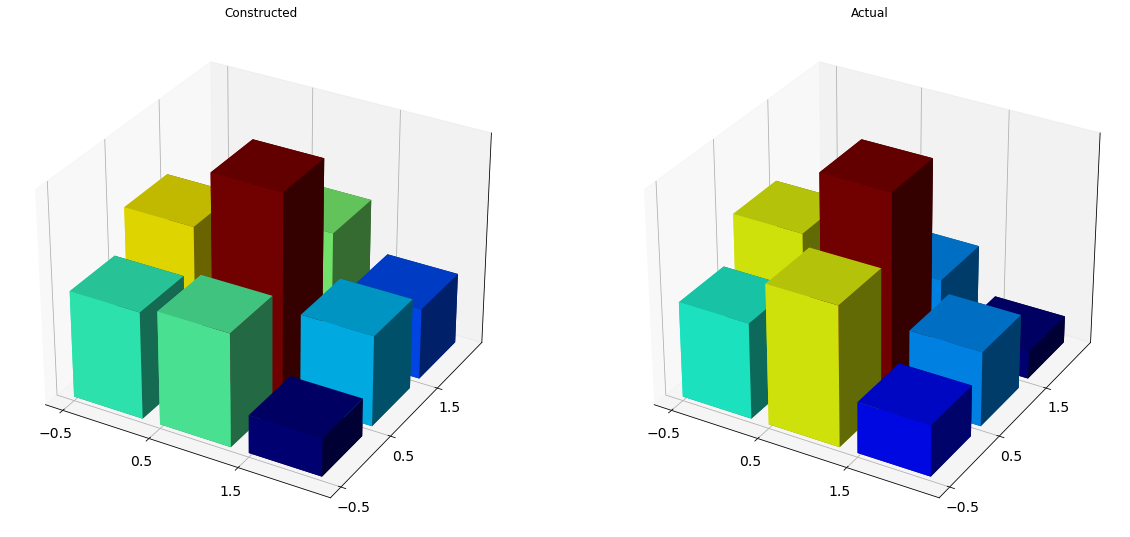

In [29]:
# Evolve the same initial state using constructed and actual evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.
t = 10

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)
state_actual_evolved = (-1j * H * t).expm() * state_actual

# Constructed evolution
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True)
iteration_op = construct_BHH_propagator_2d_grid(nx, ny, toroidal=False, n=N, d=D, κ=κ)
state_constructed_evolved = iteration_op ** t * state_constructed

plot_occupancies_2d_grid(state_constructed_evolved, state_actual_evolved, nx=nx, ny=ny)

## Animation rendering

In [21]:
# Evolve the same initial state using constructed and actual evolutions
N = 1
D = 9
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.1
tmax = 100

# Actual evolution
state_actual = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=False)
H = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, include_chemical_potential=False, include_onsite_interaction=False)

# Constructed evolution
state_constructed = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True)
iteration_op = construct_BHH_propagator_2d_grid(nx, ny, toroidal=False, n=N, d=D, κ=κ)

cumulative_iteration_op = iteration_op ** 0
for t in tqdm(range(0, tmax)):
    state_actual_evolved = (-1j * H * t).expm() * state_actual
    state_constructed_evolved = cumulative_iteration_op * state_constructed
    cumulative_iteration_op *= iteration_op
    # state_constructed_evolved = iteration_op ** t * state_constructed

    fig = plot_occupancies_2d_grid(state_constructed_evolved, state_actual_evolved, nx=nx, ny=ny, limits=[0,N])
    fig.text(0.15, 0.8, f"$t={t}, κ={κ}$", fontsize=30)

    title = str(t).zfill(8)
    plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

In [354]:
def hinton(W, xlabels = None, ylabels = None, labelsize = 9, title = None, fig = None, ax = None, cmap = None, color_mode="phase", z_limits=None):

    def _blob(x, y, w, w_min, w_max, area, cmap = None, ax = None):
        """
        Draws a square-shaped blob with the given area (< 1) at
        the given coordinates.
        """
        hs = np.sqrt(area) / 2
        xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
        ycorners = np.array([y - hs, y - hs, y + hs, y + hs])

        handle = ax if ax is not None else plt
        # color = int(256 * (w - w_min) / (w_max - w_min))
        color = (w - w_min) / (w_max - w_min)
        handle.fill(xcorners, ycorners, color = cmap(color))

    if cmap is None:
        cmap = plt.get_cmap('twilight')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize = (4, 4))

    if not (xlabels or ylabels):
        ax.axis('off')

    ax.axis('equal')
    ax.set_frame_on(False)

    height, width = W.shape
    ax.set(xlim = (0, width), ylim = (0, height))

    max_abs = np.max(np.abs(W))
    scale = 0.7

    for i in range(width):
        for j in range(height):
            x = i + 1 - 0.5
            y = j + 1 - 0.5
            if color_mode == "phase":
                _blob(x, height - y, np.angle(W[i, j]), -np.pi, np.pi,
                      np.abs(W[i, j]) / max_abs * scale, cmap = cmap, ax = ax)
            elif color_mode == "magnitude":
                if z_limits is None:
                    raise ValueError("Need z limits for magnitude shading")
                _blob(x, height - y, np.abs(W[i, j]), z_limits[0], z_limits[1],
                      np.abs(W[i, j]) / max_abs * scale, cmap = cmap, ax = ax)
            else:
                raise ValueError("Expected color_mode = 'phase' or 'magnitude")

    # x axis
    ax.xaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    if xlabels:
        ax.set_xticklabels(xlabels, rotation = 'vertical')
        ax.xaxis.tick_top()
    ax.tick_params(axis = 'x', labelsize = labelsize, pad = 0)
    ax.xaxis.set_ticks_position('none')

    # y axis
    ax.yaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.yaxis.set_ticks_position('none')
    if ylabels:
        ax.set_yticklabels(list(reversed(ylabels)))
    ax.tick_params(axis = 'y', labelsize = labelsize, pad = 0)

    # color axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    if color_mode == "phase":
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(-np.pi, np.pi), ticks = [])
        cax.text(0.5, 0.0, '$-\pi$', transform = cax.transAxes, va = 'top', ha = 'center')
        cax.text(0.5, 1.0, '$+\pi$', transform = cax.transAxes, va = 'bottom', ha = 'center')
    elif color_mode == "magnitude":
        cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(z_limits[0], z_limits[1]), ticks = [])
        cax.text(0.5, 0.0, str(z_limits[0]), transform = cax.transAxes, va = 'top', ha = 'center')
        cax.text(0.5, 1.0, str(z_limits[1]), transform = cax.transAxes, va = 'bottom', ha = 'center')
    else:
        raise ValueError("Expected color_mode = 'phase' or 'magnitude")

    # Make title in corner
    if title is not None:
        plt.text(-.07, 1.05, title, ha = 'center', va = 'center', fontsize = 22, transform = ax.transAxes)

    return fig, ax

  0%|          | 0/112 [00:00<?, ?it/s]

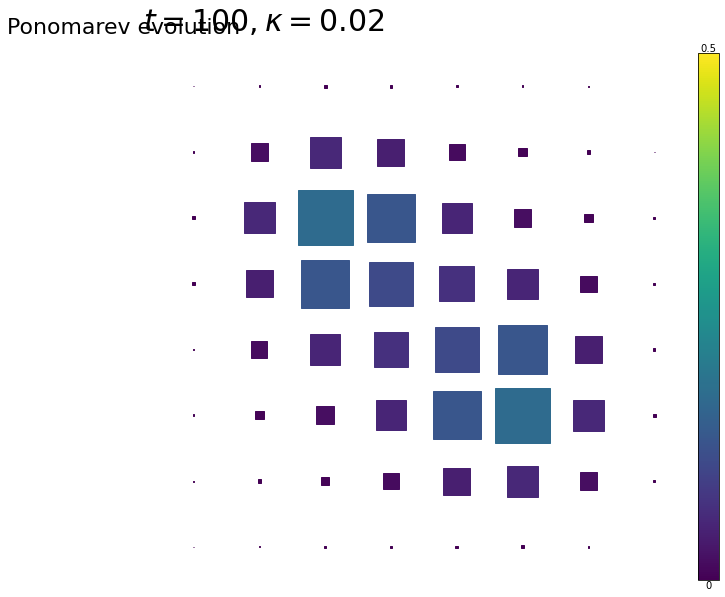

In [358]:
# Compare ponomarev vs non-ponomarev evolutions
N = 2
D = 64
nx = int(np.sqrt(D))
ny = int(np.sqrt(D))
fock = N+1

κ = 0.02
μ = 0.1
U = 0.1
tmax = 1000

# Ponomarev evolution
fock_list = [0] * D
fock_list[0] = N // 2
fock_list[D-1] = N // 2
state_pn = qt_fock_to_ponomarev(fock_list, N, D)

# state_pn = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, full_bin_index=0, include_register=True, use_ponomarev=True)
H_pn = BHH_2d_grid(nx, ny, fock=fock, toroidal=False, κ=κ, μ=μ, U=U, include_chemical_potential=True, include_onsite_interaction=True, use_ponomarev=True, display_progress=True)
# state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

# for t in tqdm(range(0,tmax)):

t= 100
state_pn_evolved = (-1j * H_pn * t).expm() * state_pn

fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2, projection='3d')

photon_occupancies_pn = np.array(get_photon_occupancies(state_pn_evolved, n_time_bins=D, n_photons=N, use_ponomarev=True)).reshape(ny,nx)
# qt.matrix_histogram(photon_occupancies_pn,fig=fig, ax=ax1, title="Ponomarev", colorbar=False, limits=[0,N])
hinton(photon_occupancies_pn, xlabels = None, ylabels = None, labelsize = 9, title = "Ponomarev evolution", fig = fig, ax = ax1, cmap = plt.get_cmap('viridis'), color_mode="magnitude", z_limits=[0, 0.5])

fig.text(0.1, 0.9, f"$t={t}, κ={κ}$", fontsize=30)

title = str(t).zfill(8)
plt.show() 
# plt.savefig("frames/evolution_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()

## Time evolved 1D grid plot thingy

In [20]:
def simulate_1d_evolution_and_save(N=2, D=32, κ=0.2, μ=1, U=1, tmax=200, toroidal=False):
    
    start = time.time()
    
    fock = N+1
    
    # Create initial state
    fock_list = [0] * D
    # photon_locations = [(D * 1) // 4, (D * 3) // 4]
    # fock_list[photon_locations[0]] = N // 2
    # fock_list[photon_locations[1]] = N // 2
    
    photon_location = D // 2 - 1
    fock_list[photon_location] = N
    
    
    use_ponomarev=False

    if use_ponomarev:
        state_initial = qt_fock_to_ponomarev(fock_list, N, D)
    else:
        state_initial = create_initial_state_all_photons_one_bin(n_time_bins=D, n_photons=N, 
                                                                 full_bin_index=photon_location,
                                                                 include_register=False,
                                                                 use_ponomarev=use_ponomarev)

    
    H = BHH_1d_line(D, fock=fock, 
                    toroidal=toroidal, 
                    κ=κ, μ=μ, U=U, 
                    include_chemical_potential=(μ!=0), 
                    include_onsite_interaction=True,#(U!=0), 
                    use_ponomarev=use_ponomarev, 
                    display_progress=False)

    photon_expectations_over_time = []
    states_over_time = []

    for t in tqdm(range(0,tmax), desc="Evolving states"):
        state_evolved = (-1j * H * t).expm() * state_initial
        states_over_time.append(state_evolved)

    photon_expectations_over_time = [np.array(get_photon_occupancies(state, n_time_bins=D, n_photons=N, use_ponomarev=use_ponomarev)) 
                                     for state in tqdm(states_over_time, desc="Computing photon expecations")]
    two_photon_correlations_over_time = [get_two_photon_correlations(state, n_time_bins=D, n_photons=N, use_ponomarev=use_ponomarev)
                                         for state in tqdm(states_over_time, desc="Computing 2-photon correlations")]
    
    # Save as pickled object
    kappa = κ
    mu = μ
    filename = f"results/1d_evolution_{N=}_{D=}_{kappa=}_{mu=}_{U=}_{tmax=}_{toroidal=}_results.pickle"
    obj = {
        "state_initial": state_initial,
        "H": H,
        "states_over_time": states_over_time,
        "photon_expectations_over_time": photon_expectations_over_time,
        "two_photon_correlations_over_time": two_photon_correlations_over_time
    }
    
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
        
    print(f"Simulation complete. Elapsed time: {time.time()-start}s. Results saved to {filename}")


In [23]:
# simulate_1d_evolution_and_save(N=2, D=30, κ=0.2, μ=0, U=0, tmax=500, toroidal=False)
simulate_1d_evolution_and_save(N=2, D=4, κ=0.3, μ=0, U=10, tmax=100, toroidal=False)

Evolving states:   0%|          | 0/100 [00:00<?, ?it/s]

Computing photon expecations:   0%|          | 0/100 [00:00<?, ?it/s]

Computing 2-photon correlations:   0%|          | 0/100 [00:00<?, ?it/s]

Simulation complete. Elapsed time: 3.4534831047058105s. Results saved to results/1d_evolution_N=2_D=4_kappa=0.3_mu=0_U=10_tmax=100_toroidal=False_results.pickle


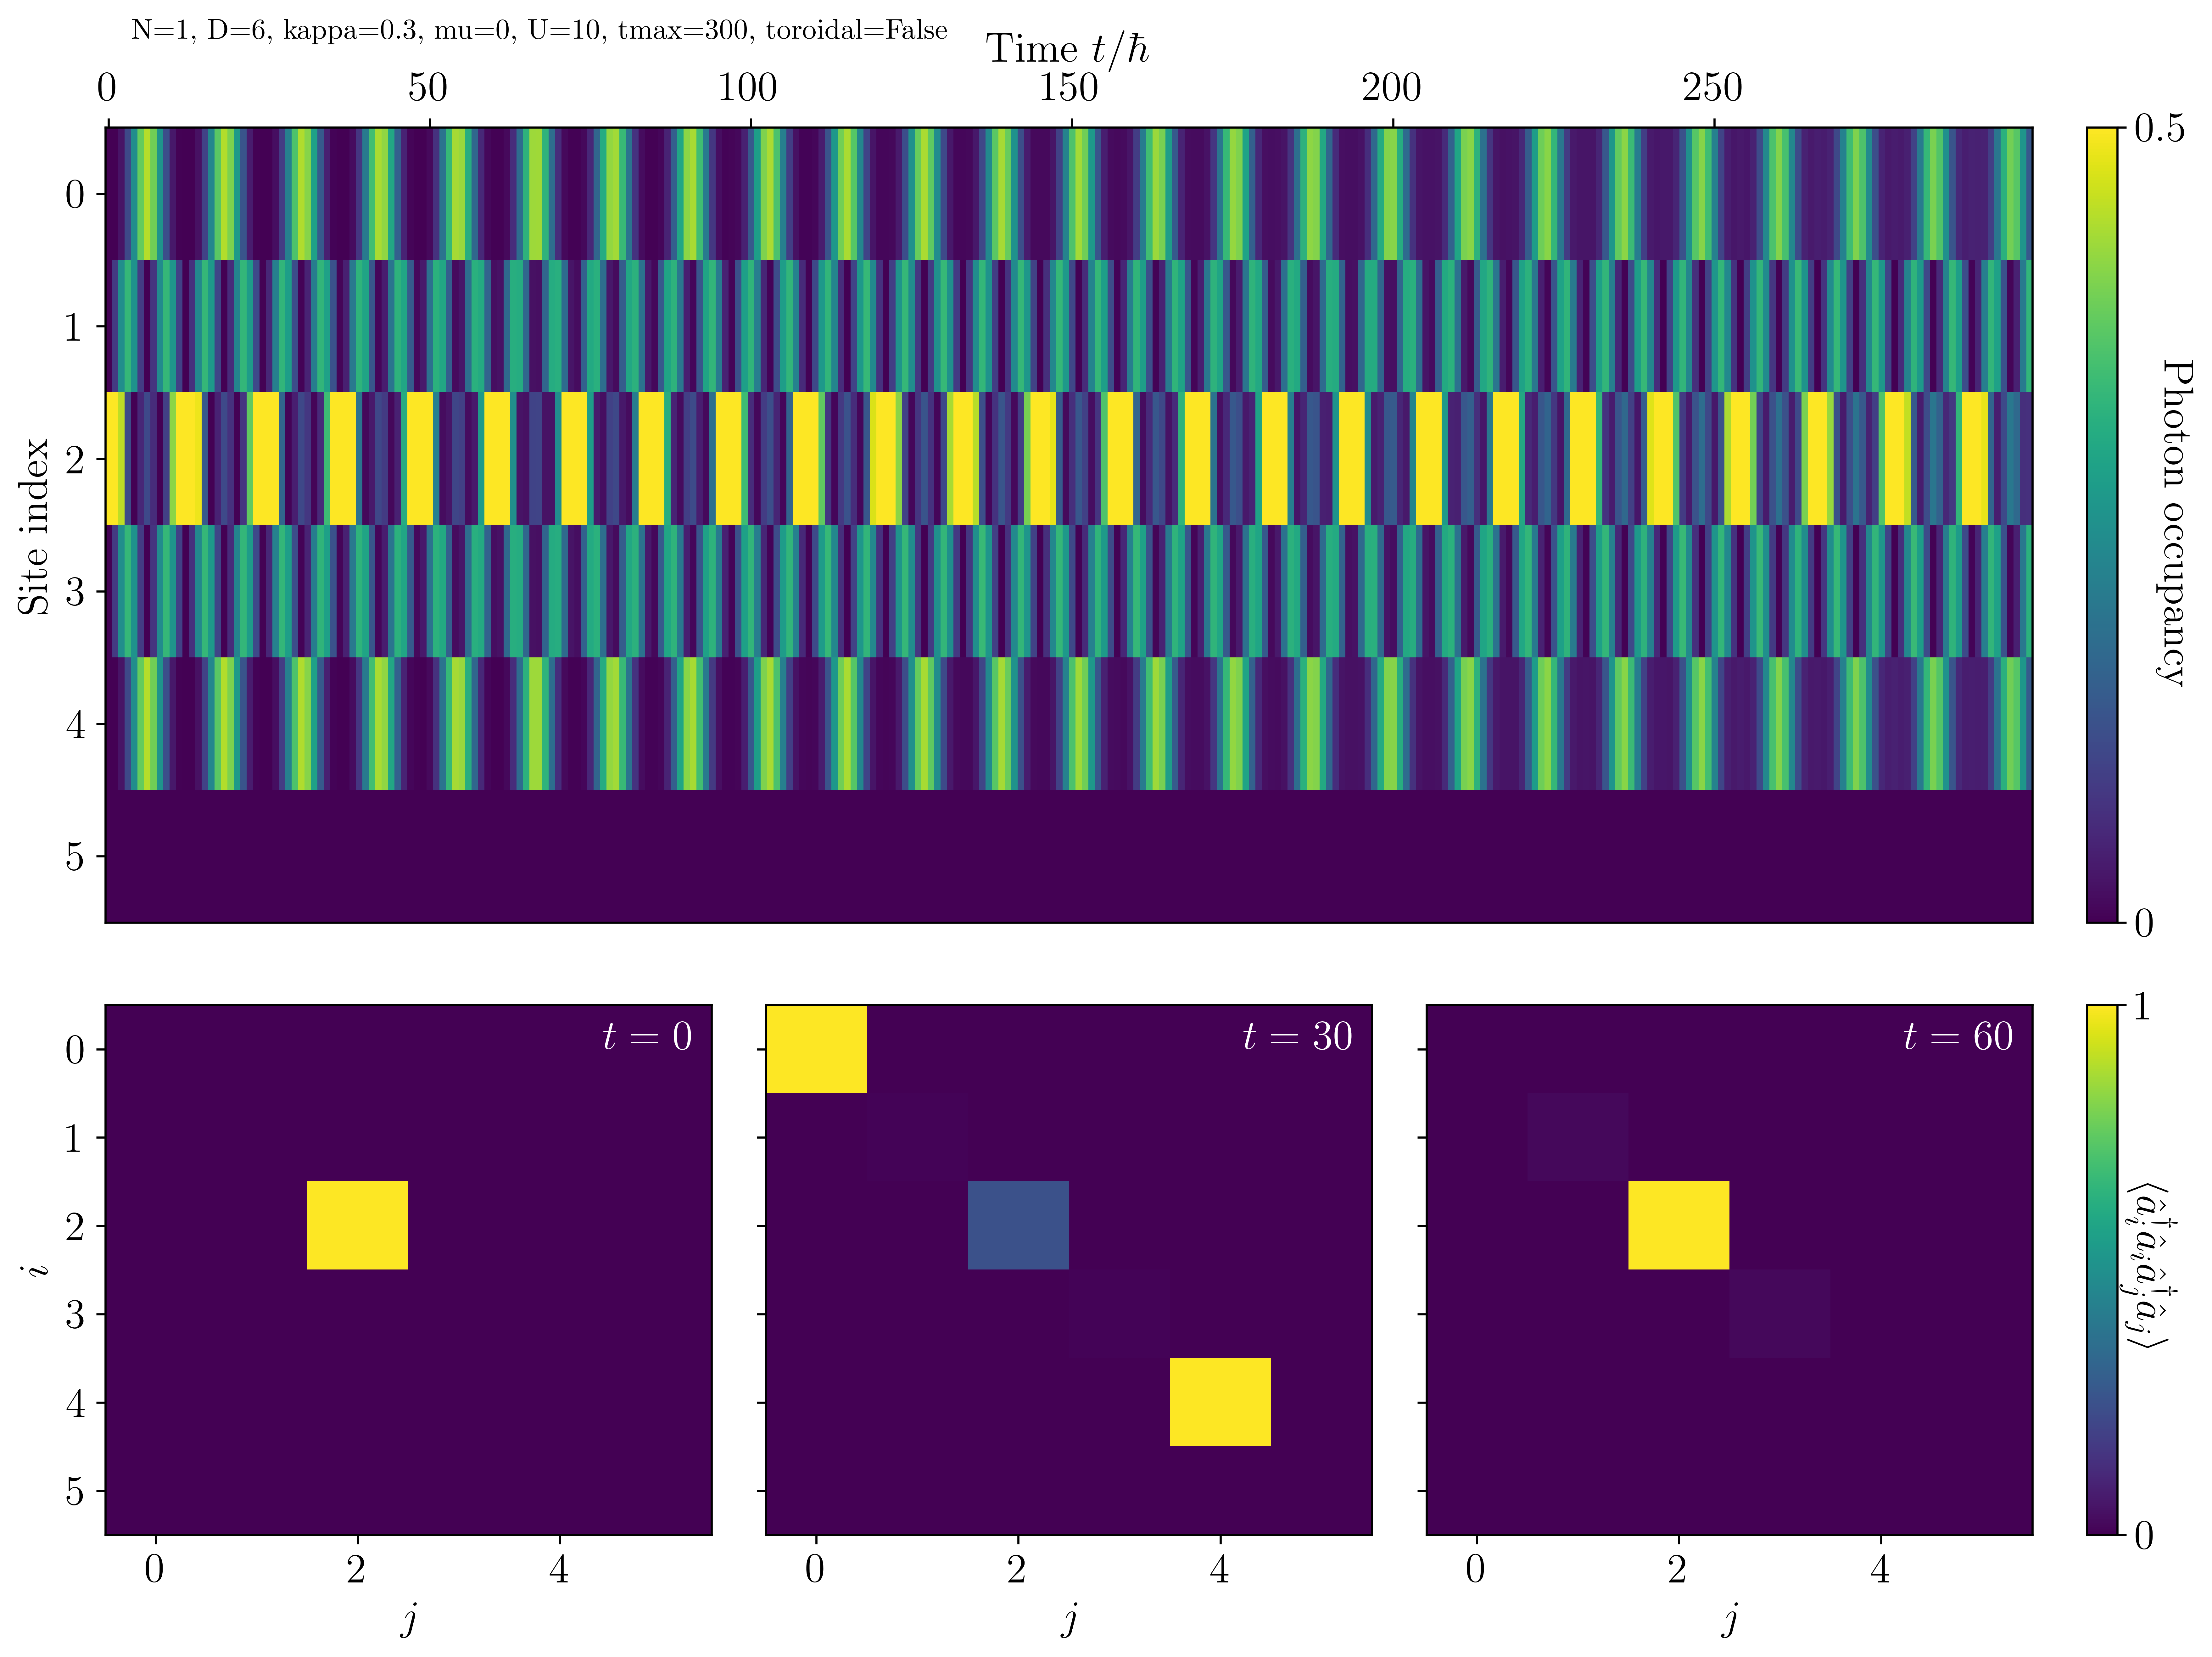

In [18]:
def plot_1d_state_evolution(photon_expectations_over_time, 
                            two_photon_correlations_over_time,
                            photon_correlation_snapshots = [0, 5, 15],
                            take_sqrt_of_amplitudes=False,
                            figscale = 12, savefig = False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .75 * figscale), tight_layout=True)
    gs = mpl.gridspec.GridSpec(nrows=2, ncols=4, 
                               height_ratios = [1.5, 1], width_ratios=[1, 1, 1, 0.05])#,
                               #hspace=0.1)

    ax = fig.add_subplot(gs[0, :-1])
    cax = fig.add_subplot(gs[0, -1])
    
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[1, 2], sharey=ax1)
    cax2 = fig.add_subplot(gs[1, -1])
    

    # Plot evolved state
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.xaxis.tick_top()
    ax.set_xlabel("Time $ t / \\hbar $")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Site index")
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_over_time)), aspect='auto', cmap=cmap, vmax=0.5)
    else:
        ax.imshow(np.transpose(photon_expectations_over_time), aspect='auto', cmap=cmap, vmax=.5)

    mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, .5), ticks = [0, .5])
    cax.set_yticklabels(["$0$", "$0.5$"])
    
    mpl.colorbar.ColorbarBase(cax2, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])
    cax2.set_yticklabels(["$0$", "$1$"])
        

    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy", rotation=270)
    cax2.get_yaxis().labelpad=8
    cax2.set_ylabel("$\\langle \\hat a_i ^ \\dagger \\hat a_i \\hat a_j ^\\dagger \\hat a_j \\rangle$", rotation=270)
    
    
    # Add 2-photon correlation subplots
    for i, axis in enumerate([ax1, ax2, ax3]):
        
        if i == 0:
            axis.set_ylabel("$i$")
            axis.set_xlabel("$j$")
            
        if i > 0:
            plt.setp(axis.get_yticklabels(), visible=False)
            axis.set_xlabel("$j$")

    
        time_index = photon_correlation_snapshots[i]
        two_photon_correlations = two_photon_correlations_over_time[time_index]
        axis.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
        axis.text(.97, 0.97, f"$t = {time_index}$", ha = 'right', va = 'top', color="white", transform = axis.transAxes)

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_from_file(filename, include_description=False, 
                                      photon_correlation_snapshots = [0, 5, 15],
                                      take_sqrt_of_amplitudes=False,
                                      savefig = False):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    
    fig = plot_1d_state_evolution(photon_expectations_over_time, two_photon_correlations_over_time, 
                        photon_correlation_snapshots = photon_correlation_snapshots,
                        take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                        savefig = savefig)
    
    if include_description:
        # variables = []
        # values = []
        conditions = []
        for txt in filename.split("_"):
            if "=" in txt:
                # variable, value = txt.split("=")
                # variables.append(variable)
                # values.append(value)
                conditions.append(txt)
        description = ", ".join(conditions)
        fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
                
    


# plot_1d_state_evolution(photon_expectations_over_time, two_photon_correlations_over_time, 
#                         photon_correlation_snapshots = [0, 5, 15],
#                         take_sqrt_of_amplitudes=False,
#                         savefig = False)
filename = "results/1d_evolution_N=1_D=6_kappa=0.3_mu=0_U=10_tmax=300_toroidal=False_results.pickle"
plot_1d_state_evolution_from_file(filename, include_description=True, 
                                  photon_correlation_snapshots = [0, 30, 60],
                                  take_sqrt_of_amplitudes=False,
                                  savefig = False)
# plt.show()
savename = filename.replace("results/", "assets/").replace(".pickle", ".pdf")
plt.savefig(savename, dpi=300, bbox_inches='tight', pad_inches=0)
# plt.show()


In [19]:
-1 % 5

4

In [67]:
def plot_two_photon_correlations(two_photon_correlations):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=14)

    fig, ax = plt.subplots(1,1, figsize=(4,4))

    # Plot state over training
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.imshow(two_photon_correlations, aspect='auto', cmap=cmap)
    # ax.set_xticks([])
    # ax.yaxis.set_major_locator(plt.IndexLocator(base=1, offset=0.35))
    # ax.yaxis.set_ticks_position('none')
    # ax.set_yticklabels(kets)
    # ax.tick_params(axis = 'y', labelsize = 10, pad = 0)
    
    # Add a colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '2%', pad = '1%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(0, 1),
                                     ticks = [0, 1])
    cax.get_yaxis().labelpad=0
    cax.set_ylabel("Two-photon correlations", rotation=270)
    cax.set_yticklabels(["$0$", "$1$"])
    
    return fig, ax, cax


# plot_two_photon_correlations(two_photon_correlations_over_time[0])
# plt.show()

# plt.savefig("1d_evolution_toroidal.pdf", dpi=300, bbox_inches='tight', pad_inches=0)

In [126]:
def plot_1d_state_evolution_animated(photon_expectations_until_time, 
                                     two_photon_correlations_at_time,
                                     tmax=None,
                                     take_sqrt_of_amplitudes=False,
                                     figscale = 12, savefig = False):
    
    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rc('font', size=16)

    fig = plt.figure(figsize=(figscale, .45 * figscale), tight_layout=True)
    gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, 
                               width_ratios=[1, 1.2, 0.05], hspace=0.0)#,
                               #hspace=0.1)

    ax1 = fig.add_subplot(gs[0, 0])
    ax = fig.add_subplot(gs[0, 1:-1], sharey=ax1)
    cax = fig.add_subplot(gs[0, -1])

    # Plot evolved state
    cmap=plt.get_cmap('viridis')
    # cmap=plt.get_cmap('plasma')
    
    ax.set_xlabel("Time $ t / \\hbar $")
    plt.setp(ax.get_yticklabels(), visible=False)
    ax1.set_ylabel("Site index $i$")
    ax1.set_xlabel("Site index $j$")
    
    if tmax is not None:
        ax.set_xlim(0, tmax)
    
    if take_sqrt_of_amplitudes:
        ax.imshow(np.sqrt(np.transpose(photon_expectations_until_time)), aspect='auto', cmap=cmap)
    else:
        ax.imshow(np.transpose(photon_expectations_until_time), aspect='auto', cmap=cmap)

    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = mpl.colors.Normalize(0, 1), ticks = [0, 1])
    cax.set_yticklabels(["$0$", "$1$"])
    cax.get_yaxis().labelpad=2
    cax.set_ylabel("Photon occupancy, correlation", rotation=270)

    ax1.imshow(two_photon_correlations_at_time, aspect='auto', cmap=cmap)
    time = len(photon_expectations_until_time)
    ax1.text(.97, 0.97, f"$t = {time}$", ha = 'right', va = 'top', color="white", transform = ax1.transAxes)

    fig.tight_layout()
    
    if savefig:
        plt.savefig("assets/1d_state_evolution.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    
    return fig

def plot_1d_state_evolution_animated_from_file(filename,
                                               t=None,
                                               include_description=False, 
                                               take_sqrt_of_amplitudes=False,
                                               savefig = False):
    with open(filename, "rb") as f:
        obj = pickle.load(f)
        
    photon_expectations_over_time = obj["photon_expectations_over_time"]
    two_photon_correlations_over_time = obj["two_photon_correlations_over_time"]
    tmax = len(photon_expectations_over_time)
    
    if t == "all" and savefig == True:
        
        # Render *ALL* the frames!
        for t in tqdm(range(1, tmax), desc="Rendering frames"):
        
            fig = plot_1d_state_evolution_animated(photon_expectations_over_time[0:t], two_photon_correlations_over_time[t], 
                                                   tmax = tmax-1,
                                                   take_sqrt_of_amplitudes=take_sqrt_of_amplitudes,
                                                   savefig = False)

            if include_description:
                conditions = []
                for txt in filename.split("_"):
                    if "=" in txt:
                        conditions.append(txt)
                description = ", ".join(conditions)
                fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)

            title = str(t).zfill(8) + "_".join(conditions) + ".png"
            plt.savefig("frames/"+title, bbox_inches='tight', pad_inches=0)
            plt.close()
    
    elif type(t) is int:
    
        fig = plot_1d_state_evolution_animated(photon_expectations_over_time[0:t], two_photon_correlations_over_time[t], 
                                               tmax = tmax,
                                               take_sqrt_of_amplitudes=take_sqrt_of_amplitudes)

        if include_description:
            conditions = []
            for txt in filename.split("_"):
                if "=" in txt:
                    conditions.append(txt)
            description = ", ".join(conditions)
            fig.text(0.07, 0.98, description, ha = 'left', va = 'top', color="black", fontsize=11)
            
    
                
    
filename = "results/1d_evolution_N=2_D=32_kappa=0.2_mu=1_U=1_tmax=100_toroidal=False_results.pickle"
plot_1d_state_evolution_animated_from_file(filename, include_description=True,
                                           t="all",
                                           take_sqrt_of_amplitudes=False,
                                           savefig = True)       
# plt.show()

Rendering frames:   0%|          | 0/99 [00:00<?, ?it/s]

In [167]:
for filename in glob.glob("results/*"):
    framename = filename.replace("results/1d_evolution_", "frames/*").replace("_results.pickle", ".png")
    videoname = filename.replace("results/1d_evolution_", "assets/1d_evolution_").replace("_results.pickle", ".mp4")
    print(framename)
    os.system(f'ffmpeg -framerate 60 -pattern_type glob -i "{framename}" -filter:v scale="trunc(oh*a/2)*2:1080" -pix_fmt yuv420p {videoname}')

frames/*N=2_D=50_kappa=0.01_mu=1.0_U=10.0_tmax=1000_toroidal=True.png


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample

frames/*N=2_D=50_kappa=0.1_mu=1.0_U=10.0_tmax=1000_toroidal=True.png


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample

frames/*N=2_D=50_kappa=0.01_mu=1.0_U=0.0_tmax=1000_toroidal=True.png


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample

frames/*N=2_D=50_kappa=0.1_mu=1.0_U=0.0_tmax=1000_toroidal=True.png


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 13.0.0 (clang-1300.0.29.3)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/4.4.1_5 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample

frames/*N=2_D=50_kappa=0.01_mu=1.0_U=1.0_tmax=1000_toroidal=False.png


frame=  999 fps= 25 q=-1.0 Lsize=    1453kB time=00:00:16.60 bitrate= 717.0kbits/s speed=0.42x     
video:1441kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.842180%
[libx264 @ 0x11580a200] frame I:4     Avg QP:18.64  size: 46216
[libx264 @ 0x11580a200] frame P:284   Avg QP:23.27  size:  3015
[libx264 @ 0x11580a200] frame B:711   Avg QP:26.76  size:   610
[libx264 @ 0x11580a200] consecutive B-frames:  2.3%  3.0% 16.2% 78.5%
[libx264 @ 0x11580a200] mb I  I16..4: 30.8% 58.4% 10.8%
[libx264 @ 0x11580a200] mb P  I16..4:  1.1%  1.2%  0.2%  P16..4:  3.2%  0.5%  0.3%  0.0%  0.0%    skip:93.5%
[libx264 @ 0x11580a200] mb B  I16..4:  0.2%  0.1%  0.0%  B16..8:  3.3%  0.1%  0.0%  direct: 0.0%  skip:96.3%  L0:42.2% L1:56.6% BI: 1.2%
[libx264 @ 0x11580a200] 8x8 transform intra:48.2% inter:72.8%
[libx264 @ 0x11580a200] coded y,uvDC,uvAC intra: 10.9% 31.5% 11.2% inter: 0.4% 0.6% 0.1%
[libx264 @ 0x11580a200] i16 v,h,dc,p: 66% 28%  3%  2%
[libx264 @ 0x11580a200] i8 v,h,

frames/*N=2_D=50_kappa=0.01_mu=1.0_U=10.0_tmax=1000_toroidal=False.png


[libx264 @ 0x12c01d800] using SAR=2927/2925
[libx264 @ 0x12c01d800] using cpu capabilities: ARMv8 NEON
[libx264 @ 0x12c01d800] profile High, level 5.1, 4:2:0, 8-bit
[libx264 @ 0x12c01d800] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=15 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to 'assets/1d_evolution_N=2_D=50_kappa=0.01_mu=1.0_U=10.0_tmax=1000_toroidal=False.mp4':
  Metadata:
    encoder         : Lavf58.7

frames/*N=2_D=50_kappa=0.01_mu=1.0_U=0.0_tmax=1000_toroidal=False.png


[libx264 @ 0x117808e00] using cpu capabilities: ARMv8 NEON
[libx264 @ 0x117808e00] profile High, level 5.1, 4:2:0, 8-bit
[libx264 @ 0x117808e00] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=15 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to 'assets/1d_evolution_N=2_D=50_kappa=0.01_mu=1.0_U=0.0_tmax=1000_toroidal=False.mp4':
  Metadata:
    encoder         : Lavf58.76.100
  Stream #0:0: Video: h264 (avc1 / 0x31

frames/*N=2_D=50_kappa=0.1_mu=1.0_U=1.0_tmax=1000_toroidal=False.png


frame=  999 fps= 25 q=-1.0 Lsize=    3462kB time=00:00:16.60 bitrate=1708.6kbits/s speed=0.417x    
video:3450kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.343311%
[libx264 @ 0x14b01d800] frame I:4     Avg QP:19.34  size: 58436
[libx264 @ 0x14b01d800] frame P:285   Avg QP:25.12  size:  7011
[libx264 @ 0x14b01d800] frame B:710   Avg QP:25.55  size:  1832
[libx264 @ 0x14b01d800] consecutive B-frames:  2.1%  0.0% 28.2% 69.7%
[libx264 @ 0x14b01d800] mb I  I16..4: 36.6% 53.8%  9.7%
[libx264 @ 0x14b01d800] mb P  I16..4:  3.0%  7.9%  0.6%  P16..4:  6.7%  0.9%  0.3%  0.0%  0.0%    skip:80.6%
[libx264 @ 0x14b01d800] mb B  I16..4:  0.5%  0.4%  0.0%  B16..8:  8.7%  0.4%  0.0%  direct: 0.2%  skip:89.7%  L0:47.1% L1:50.9% BI: 2.0%
[libx264 @ 0x14b01d800] 8x8 transform intra:63.6% inter:89.2%
[libx264 @ 0x14b01d800] coded y,uvDC,uvAC intra: 11.1% 30.2% 8.5% inter: 0.8% 1.1% 0.1%
[libx264 @ 0x14b01d800] i16 v,h,dc,p: 58% 33%  6%  3%
[libx264 @ 0x14b01d800] i8 v,h,d

frames/*N=2_D=50_kappa=0.1_mu=1.0_U=0.0_tmax=1000_toroidal=False.png


[libx264 @ 0x13001ca00] using SAR=2927/2925
[libx264 @ 0x13001ca00] using cpu capabilities: ARMv8 NEON
[libx264 @ 0x13001ca00] profile High, level 5.1, 4:2:0, 8-bit
[libx264 @ 0x13001ca00] 264 - core 163 r3060 5db6aa6 - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=15 lookahead_threads=2 sliced_threads=0 nr=0 decimate=1 interlaced=0 bluray_compat=0 constrained_intra=0 bframes=3 b_pyramid=2 b_adapt=1 b_bias=0 direct=1 weightb=1 open_gop=0 weightp=2 keyint=250 keyint_min=25 scenecut=40 intra_refresh=0 rc_lookahead=40 rc=crf mbtree=1 crf=23.0 qcomp=0.60 qpmin=0 qpmax=69 qpstep=4 ip_ratio=1.40 aq=1:1.00
Output #0, mp4, to 'assets/1d_evolution_N=2_D=50_kappa=0.1_mu=1.0_U=0.0_tmax=1000_toroidal=False.mp4':
  Metadata:
    encoder         : Lavf58.76.

frames/*N=2_D=50_kappa=0.1_mu=1.0_U=1.0_tmax=1000_toroidal=True.png


frame=  999 fps= 25 q=-1.0 Lsize=    3794kB time=00:00:16.60 bitrate=1872.1kbits/s speed=0.417x    
video:3782kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.315517%
[libx264 @ 0x11f01d800] frame I:4     Avg QP:19.93  size: 60148
[libx264 @ 0x11f01d800] frame P:284   Avg QP:24.86  size:  7792
[libx264 @ 0x11f01d800] frame B:711   Avg QP:25.47  size:  1995
[libx264 @ 0x11f01d800] consecutive B-frames:  2.3%  0.2% 24.6% 72.9%
[libx264 @ 0x11f01d800] mb I  I16..4: 29.1% 60.4% 10.5%
[libx264 @ 0x11f01d800] mb P  I16..4:  3.3%  8.2%  0.6%  P16..4:  7.6%  1.1%  0.3%  0.0%  0.0%    skip:78.9%
[libx264 @ 0x11f01d800] mb B  I16..4:  0.6%  0.5%  0.0%  B16..8:  9.3%  0.5%  0.0%  direct: 0.2%  skip:88.8%  L0:47.2% L1:50.7% BI: 2.1%
[libx264 @ 0x11f01d800] 8x8 transform intra:63.1% inter:89.5%
[libx264 @ 0x11f01d800] coded y,uvDC,uvAC intra: 11.6% 31.8% 8.5% inter: 0.9% 1.3% 0.1%
[libx264 @ 0x11f01d800] i16 v,h,dc,p: 56% 34%  6%  3%
[libx264 @ 0x11f01d800] i8 v,h,d

frames/*N=2_D=50_kappa=0.01_mu=1.0_U=1.0_tmax=1000_toroidal=True.png


frame=  999 fps= 25 q=-1.0 Lsize=    1441kB time=00:00:16.60 bitrate= 710.9kbits/s speed=0.422x    
video:1428kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.848394%
[libx264 @ 0x14681d800] frame I:4     Avg QP:18.44  size: 46013
[libx264 @ 0x14681d800] frame P:283   Avg QP:22.94  size:  3002
[libx264 @ 0x14681d800] frame B:712   Avg QP:26.60  size:   602
[libx264 @ 0x14681d800] consecutive B-frames:  2.1%  3.0% 16.8% 78.1%
[libx264 @ 0x14681d800] mb I  I16..4: 32.8% 56.5% 10.6%
[libx264 @ 0x14681d800] mb P  I16..4:  1.1%  1.2%  0.2%  P16..4:  3.2%  0.6%  0.3%  0.0%  0.0%    skip:93.5%
[libx264 @ 0x14681d800] mb B  I16..4:  0.2%  0.0%  0.0%  B16..8:  3.3%  0.1%  0.0%  direct: 0.0%  skip:96.3%  L0:41.6% L1:57.2% BI: 1.2%
[libx264 @ 0x14681d800] 8x8 transform intra:48.0% inter:72.3%
[libx264 @ 0x14681d800] coded y,uvDC,uvAC intra: 10.7% 31.0% 11.0% inter: 0.3% 0.6% 0.1%
[libx264 @ 0x14681d800] i16 v,h,dc,p: 68% 27%  3%  2%
[libx264 @ 0x14681d800] i8 v,h,

frames/*N=2_D=50_kappa=0.1_mu=1.0_U=10.0_tmax=1000_toroidal=False.png


frame=  999 fps= 25 q=-1.0 Lsize=    3469kB time=00:00:16.60 bitrate=1712.1kbits/s speed=0.417x    
video:3458kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.343735%
[libx264 @ 0x15381d800] frame I:4     Avg QP:19.65  size: 58479
[libx264 @ 0x15381d800] frame P:286   Avg QP:25.10  size:  6992
[libx264 @ 0x15381d800] frame B:709   Avg QP:25.61  size:  1842
[libx264 @ 0x15381d800] consecutive B-frames:  2.4%  0.0% 26.7% 70.9%
[libx264 @ 0x15381d800] mb I  I16..4: 30.5% 59.8%  9.6%
[libx264 @ 0x15381d800] mb P  I16..4:  3.0%  7.9%  0.6%  P16..4:  6.7%  0.9%  0.3%  0.0%  0.0%    skip:80.7%
[libx264 @ 0x15381d800] mb B  I16..4:  0.5%  0.4%  0.0%  B16..8:  8.7%  0.4%  0.0%  direct: 0.2%  skip:89.6%  L0:47.0% L1:51.0% BI: 2.0%
[libx264 @ 0x15381d800] 8x8 transform intra:64.2% inter:89.1%
[libx264 @ 0x15381d800] coded y,uvDC,uvAC intra: 11.0% 30.3% 8.5% inter: 0.8% 1.1% 0.1%
[libx264 @ 0x15381d800] i16 v,h,dc,p: 58% 34%  6%  3%
[libx264 @ 0x15381d800] i8 v,h,d

## Plot code copied from other places

In [ ]:
def plot_frames(filepath, num_qubits=N, num_epochs=None):
    
    f = h5py.File(filepath, 'r')
    
    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    
    num_epochs = len(fidelities_train) if num_epochs is None else num_epochs

    operator_targ = extract_operator_from_circuit(QFT, num_qubits)
    kets, bras = computational_basis_labels(num_qubits, include_bras=True)
    
    for i in pbar(range(num_epochs)):
        
        global_phase = np.mean(np.angle(operators[i]/operator_targ))
        operator = operators[i] / np.exp(1j * global_phase)

        # Make figure and axis layout
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')
        fig = plt.figure(figsize=(12,9), tight_layout=True)
        gs = mpl.gridspec.GridSpec(2, 2, height_ratios = [2, 1])

        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])

        # Plot operator visualizations
        hinton(operator, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}$")
        hinton(operator_targ, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\hat{U}$")

        # Plot antifidelity
        fidel_val = fidelities_val[0:i]
        fidel_train = fidelities_train[0:i]
        ax_bot = fig.add_subplot(gs[1, :])
        loss_plot(fidel_val, fidel_train, x_units='iterations', x_max = num_epochs, fig=fig, ax=ax_bot)

        # Save frame
        title = str(i).zfill(4)
        plt.savefig("assets/frames/qft_{}.png".format(title), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

In [ ]:
def matrix_histogram(M, xlabels=None, ylabels=None, title=None, limits=None,
                     colorbar=True, fig=None, ax=None):
    """
    Draw a histogram for the matrix M, with the given x and y labels and title.

    Parameters
    ----------
    M : Matrix of Qobj
        The matrix to visualize

    xlabels : list of strings
        list of x labels

    ylabels : list of strings
        list of y labels

    title : string
        title of the plot (optional)

    limits : list/array with two float numbers
        The z-axis limits [min, max] (optional)

    ax : a matplotlib axes instance
        The axes context in which the plot will be drawn.

    Returns
    -------
    fig, ax : tuple
        A tuple of the matplotlib figure and axes instances used to produce
        the figure.

    Raises
    ------
    ValueError
        Input argument is not valid.

    """

    if isinstance(M, Qobj):
        # extract matrix data from Qobj
        M = M.full()

    n = np.size(M)
    xpos, ypos = np.meshgrid(range(M.shape[0]), range(M.shape[1]))
    xpos = xpos.T.flatten() - 0.5
    ypos = ypos.T.flatten() - 0.5
    zpos = np.zeros(n)
    dx = dy = 0.8 * np.ones(n)
    dz = np.real(M.flatten())

    if isinstance(limits, list) and len(limits) == 2:
        z_min = limits[0]
        z_max = limits[1]
    else:
        z_min = min(dz)
        z_max = max(dz)
        if z_min == z_max:
            z_min -= 0.1
            z_max += 0.1

    norm = mpl.colors.Normalize(z_min, z_max)
    cmap = cm.get_cmap('jet')  # Spectral
    colors = cmap(norm(dz))

    if ax is None:
        fig = plt.figure()
        ax = _axes3D(fig, azim=-35, elev=35)

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors)

    if title and fig:
        ax.set_title(title)

    # x axis
    xtics = -0.5 + np.arange(M.shape[0])
    ax.axes.w_xaxis.set_major_locator(plt.FixedLocator(xtics))
    if xlabels:
        nxlabels = len(xlabels)
        if nxlabels != len(xtics):
            raise ValueError(f"got {nxlabels} xlabels but needed {len(xtics)}")
        ax.set_xticklabels(xlabels)
    ax.tick_params(axis='x', labelsize=14)

    # y axis
    ytics = -0.5 + np.arange(M.shape[1])
    ax.axes.w_yaxis.set_major_locator(plt.FixedLocator(ytics))
    if ylabels:
        nylabels = len(ylabels)
        if nylabels != len(ytics):
            raise ValueError(f"got {nylabels} ylabels but needed {len(ytics)}")
        ax.set_yticklabels(ylabels)
    ax.tick_params(axis='y', labelsize=14)

    # z axis
    ax.axes.w_zaxis.set_major_locator(plt.IndexLocator(1, 0.5))
    ax.set_zlim3d([min(z_min, 0), z_max])

    # color axis
    if colorbar:
        cax, kw = mpl.colorbar.make_axes(ax, shrink=.75, pad=.0)
        mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)

    return fig, ax

In [ ]:
def plot_qft_figure(filepath, t1 = 0, t2 = 25, tmax = 50, figscale = 12, savefig = False):

    f = h5py.File(filepath, 'r')

    fidelities_train = np.array(f['fidelities_train'])
    fidelities_val = np.array(f['fidelities_val'])
    operators = np.array(f['operators'])
    fidelity_init = 1 - np.array(f['fidelity_initial'])[-1]
    operator_init = np.array(f['operator_initial'])
    
    fidelities_val = np.insert(fidelities_val, 0, fidelity_init, axis=0)
    fidelities_train = np.insert(fidelities_train, 0, fidelity_init, axis=0)
    operators = np.insert(operators, 0, operator_init, axis=0)
    
    operator_targ = extract_operator_from_circuit(QFT, N)
    kets, bras = computational_basis_labels(N, include_bras=True)

    global_phase1 = np.mean(np.angle(operators[t1]/operator_targ))
    operator1 = operators[t1] / np.exp(1j * global_phase1)

    global_phase2 = np.mean(np.angle(operators[t2]/operator_targ))
    operator2 = operators[t2] / np.exp(1j * global_phase2)
    
    global_phase3 = np.mean(np.angle(operators[tmax]/operator_targ))
    operator3 = operators[tmax] / np.exp(1j * global_phase3)

    # Make figure and axis layout
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(figscale, figscale*(1/3 + 1/6)), tight_layout=True)
    gs = mpl.gridspec.GridSpec(2, 3, height_ratios = [2, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    
    # Plot antifidelity
    fidel_val = fidelities_val[0:tmax+1]
    fidel_train = fidelities_train[0:tmax+1]
    ax_bot = fig.add_subplot(gs[1, :])
    loss_plot(fidel_val, fidel_train, x_units='epochs', x_max = tmax+1, fig=fig, ax=ax_bot, log_fidelity=False)

    # Plot operator visualizations
    fidel1 = fidel_val[t1]
    hinton(operator1, xlabels=kets, ylabels=bras, fig=fig, ax=ax1, title="$\\tilde{U}_{"+str(t1)+"}$")
    
    fidel2 = fidel_val[t2]
    hinton(operator2, xlabels=kets, ylabels=bras, fig=fig, ax=ax2, title="$\\tilde{U}_{"+str(t2)+"}$")
    
    fidel_3 = fidel_val[tmax]
    hinton(operator3, xlabels=kets, ylabels=bras, fig=fig, ax=ax3, title="$\\tilde{U}_{"+str(tmax)+"}$")

    if savefig:
        plt.savefig("assets/qft_3panel.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    else:
        plt.show()
    
plot_qft_figure('logs/operator_history_4_qubits_2019.08.27.11.03.16.h5', t1=10, t2=20, tmax=50, savefig=False)

## Scratch work

In [85]:
N = 2
a1 = qt.tensor([qt.destroy(N), qt.qeye(N)])
a2 = qt.tensor([qt.qeye(N), qt.destroy(N)])
II = qt.tensor([qt.qeye(N), qt.qeye(N)])
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [86]:
(1j*np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())) + II

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          1.        +0.j         -0.13884009+0.13884009j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13884009+0.13884009j  1.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [96]:
(1j * np.pi/16 * np.exp(1j*np.pi/4) * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.99993807-0.01927649j -0.13794625+0.13973049j
   0.        +0.j        ]
 [ 0.        +0.j         -0.13794625+0.13973049j  0.99993807-0.01927649j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   1.        +0.j        ]]

In [95]:
(1j * np.pi/16 * (a1.dag() * a2 + a1 * a2.dag())).expm() * np.exp(1j*np.pi/4)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[2.19328005+0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         2.15113679+0.j         0.        +0.42788771j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.42788771j 2.15113679+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  2.19328005+0.j        ]]

In [105]:
(1j * np.pi/4 * (a1.dag() * a2 + a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.70710678j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.70710678j 0.70710678+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  1.        +0.j        ]]

In [107]:
(1j * np.pi/4 * (np.exp(-1j*np.pi/4)*a1.dag() * a2 + np.exp(1j*np.pi/4) * a1 * a2.dag())).expm()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j   0.        +0.j   0.        +0.j   0.        +0.j ]
 [ 0.        +0.j   0.70710678+0.j  -0.5       +0.5j  0.        +0.j ]
 [ 0.        +0.j   0.5       +0.5j  0.70710678+0.j   0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   1.        +0.j ]]